El objetivo es predecir que clientes de Paquete Premium de la foto al 30-jun-2021 se darán de baja durante agosto-2021, es decir predecir las BAJA+2 de la foto de 202106

In [ ]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree,  _tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

from joblib import Parallel, delayed

from time import time

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances


# 1. Lectura de datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/FCEN_DMEYF/'


In [ ]:
ganancia_acierto = 273000
costo_estimulo = 7000

mes_train = 202102
mes_test = 202104

# son mis
semillas = [100183,200003,300017,700001,800011]


Archivo con Clase Ternaria

In [ ]:
# dato=pd.read_csv(f"{dataset_path}/Datos_crudos/competencia_01_pandas.csv")
df=pd.read_csv(f"{dataset_path}competencia_01_v1.csv")

In [ ]:
# dato.loc[dato['foto_mes']==202104].shape


In [ ]:
df.loc[df['foto_mes']==202104].shape

(164090, 155)

In [ ]:
dato.head(9)

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,CLASE_TERNARIA
0,249221109,202101,1,0,0,61,300,1664.94,17994.40,1605.81,...,4.0,0.0,-37098.90,0.00,7867.0,118514.88,10.0,0.0,76538.25,CONTINUA
1,249221109,202102,1,0,0,61,301,1002.92,18337.34,1312.91,...,-3.0,0.0,-126627.68,1219.19,7895.0,28941.76,13.0,0.0,2545.41,CONTINUA
2,249221109,202103,1,0,0,61,302,769.74,18596.58,1662.56,...,1.0,0.0,-31388.56,0.00,7926.0,9564.73,9.0,0.0,1536.63,CONTINUA
3,249221109,202104,1,0,0,62,303,1532.79,19935.00,1899.52,...,2.0,0.0,-11773.53,0.00,7956.0,18078.27,10.0,0.0,1067.43,CONTINUA
4,249221109,202105,1,0,0,62,304,1804.14,20862.15,2693.91,...,5.0,0.0,-19480.30,0.00,7987.0,20336.57,9.0,0.0,199.41,NaN
5,249221109,202106,1,0,0,62,305,399.88,20332.88,2115.35,...,0.0,0.0,-20783.64,0.00,8017.0,16701.69,9.0,0.0,1313.76,NaN
6,249221468,202101,1,0,0,53,37,4879.78,18640.95,1149.08,...,4.0,0.0,-9864.93,0.00,1124.0,31427.14,14.0,0.0,0.00,CONTINUA
7,249221468,202102,1,0,0,53,38,739.04,12733.93,814.14,...,-3.0,0.0,0.00,0.00,1152.0,41242.51,17.0,0.0,0.00,CONTINUA
8,249221468,202103,1,0,0,53,39,-1051.55,13816.08,3453.98,...,1.0,0.0,-39792.85,0.00,1183.0,15550.67,14.0,0.0,0.00,CONTINUA


In [ ]:
X = dato[dato['foto_mes'] == mes_train]
y = X['CLASE_TERNARIA']
X = X.drop(columns=['CLASE_TERNARIA'])

NameError: name 'dato' is not defined

In [ ]:
#con el df_ competencia_01_v1
X = df[df['foto_mes'] == 202104]
y = X['clase_ternaria']
X = X.drop(columns=['clase_ternaria'])

In [ ]:
# cantidad categorias hay en clase ternaria
df['clase_ternaria'].value_counts()

,count
clase_ternaria,
CONTINUA,645053
BAJA+1,4614
BAJA+2,3972


In [ ]:
df['clase_ternaria'].value_counts()

,count
clase_ternaria,
CONTINUA,645053
BAJA+1,4614
BAJA+2,3972


Funcion de Ganancia

In [ ]:
def ganancia(model, X, y, prop=1, threshold=0.025):

  class_index = np.where(model.classes_ == "BAJA+2")[0][0]
  y_hat = model.predict_proba(X)

  @np.vectorize
  def ganancia_row(predicted, actual, threshold=0.025):
    return  (predicted >= threshold) * (ganancia_acierto if actual == "BAJA+2" else -costo_estimulo)

  return ganancia_row(y_hat[:,class_index], y).sum() / prop


Buscaremos un mejor modelo de manera inteligente:

In [ ]:
print(semillas)

[100183, 200003, 300017, 700001, 800011]


In [ ]:

sss_opt = ShuffleSplit(n_splits=5, test_size=0.3, random_state=semillas[0])

def objective(trial, X, y, sss):
  criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
  max_depth = trial.suggest_int('max_depth', 2, 20)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 200)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
  max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 20)

  def train_and_evaluate(train_index, test_index, X, y):
    m = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_leaf_nodes=max_leaf_nodes,
        random_state=semillas[0],
    )
    m.fit(X.iloc[train_index],y.iloc[train_index])
    ganancia_value = ganancia(m, X.iloc[test_index], y.iloc[test_index], prop=0.3)
    return ganancia_value

  results = Parallel(n_jobs=-1)(
      delayed(train_and_evaluate)(train_index, test_index, X, y)
      for train_index, test_index in sss.split(X)
  )

  return np.mean(results)

storage_name = "sqlite:////content/drive/MyDrive/FCEN_DMEYF/optimization_tree_v3.db"
study_name = "exp_101_decision-tree-opt-v3"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2024-09-15 22:11:06,119] A new study created in RDB with name: exp_101_decision-tree-opt-v3


In [ ]:
# No quiero que se ejecute automaticamente
study.optimize(lambda trial: objective(trial, X, y, sss_opt), n_trials=100)

[I 2024-09-15 22:45:23,799] Trial 23 finished with value: 104785333.33333334 and parameters: {'criterion': 'gini', 'max_depth': 18, 'min_samples_split': 40, 'min_samples_leaf': 20, 'max_leaf_nodes': 11}. Best is trial 20 with value: 105798000.00000001.
[I 2024-09-15 22:45:52,613] Trial 24 finished with value: 103908000.00000001 and parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 19, 'max_leaf_nodes': 15}. Best is trial 20 with value: 105798000.00000001.
[I 2024-09-15 22:46:20,167] Trial 25 finished with value: 103436666.66666667 and parameters: {'criterion': 'gini', 'max_depth': 18, 'min_samples_split': 37, 'min_samples_leaf': 16, 'max_leaf_nodes': 12}. Best is trial 20 with value: 105798000.00000001.
[I 2024-09-15 22:46:46,015] Trial 26 finished with value: 102722666.66666667 and parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 51, 'min_samples_leaf': 20, 'max_leaf_nodes': 9}. Best is trial 20 with value: 105798000.

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

In [ ]:
plot_param_importances(study)

In [ ]:
#Trial 86 finished with value: 69118000.00000001 and parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 133, 'min_samples_leaf': 10, 'max_leaf_nodes': 16}. Best is trial 86 with value: 69118000.00000001.

In [ ]:
# #completar con el best
# model_ceci = DecisionTreeClassifier(criterion='entropy',
#                                     max_depth=9,
#                                     min_samples_split=133,
#                                     min_samples_leaf=10,
#                                     max_leaf_nodes= 16,
#                                   random_state=semillas[0])
# model_ceci.fit(X,y)


# print(f"Ganancia de modelo Base: {ganancia(model_ceci, X, y)}")


Ganancia de modelo Base: 61908000.0


{'criterion': 'gini', 'max_depth': 18, 'min_samples_split': 42, 'min_samples_leaf': 20, 'max_leaf_nodes': 12

In [ ]:
# Obtener el mejor modelo
best_trial = study.best_trial
best_model_params = best_trial.params
print("Mejor modelo:", best_model_params)

model_best = DecisionTreeClassifier(**best_model_params, random_state=semillas[0])
model_best.fit(X, y)

print(f"Ganancia del mejor modelo: {ganancia(model_best, X, y)}")

Mejor modelo: {'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 161, 'min_samples_leaf': 6, 'max_leaf_nodes': 13}
Ganancia del mejor modelo: 115248000.0


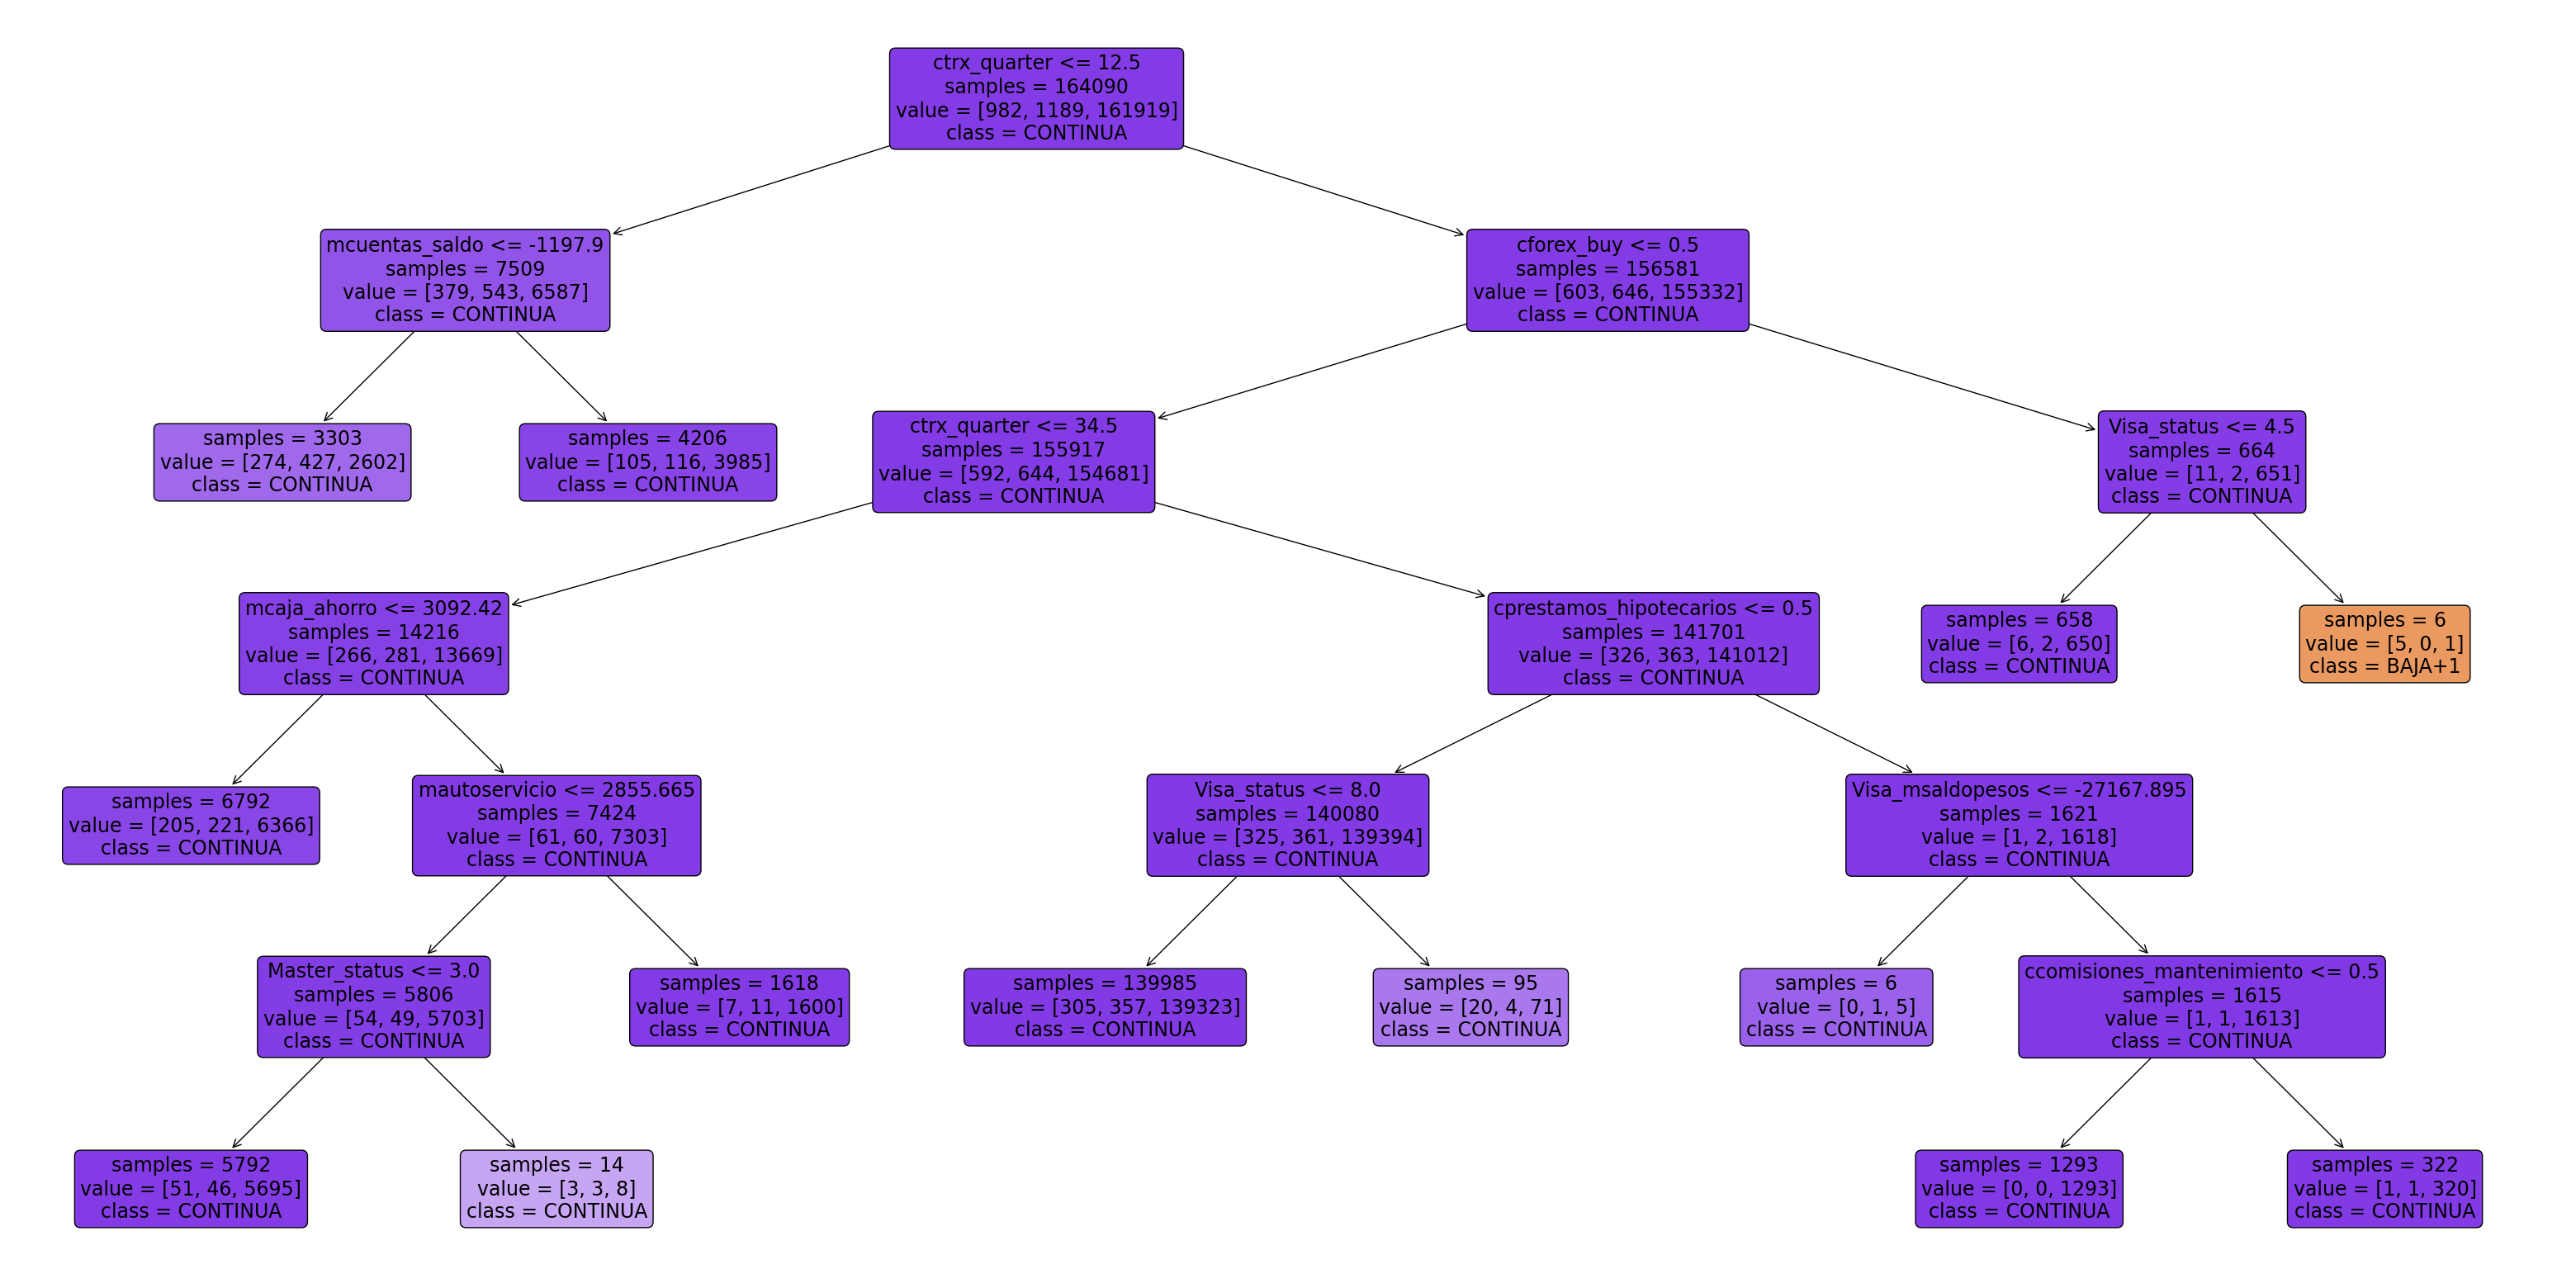

In [ ]:
#visualizacion del arbol
plt.figure(figsize=(40,20))
plot_tree(model_best, feature_names=X.columns, filled=True, class_names=model_best.classes_, rounded=True, impurity=False) #,  proportion=True)
plt.show()

In [ ]:
#explorando las variables mas importantes
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': model_best.feature_importances_})
feature_importances.sort_values('importance', ascending=False)

,feature,importance
25,mautoservicio,0.001172
107,ctrx_quarter,0.001100
18,mcaja_ahorro,0.000012
111,Master_status,0.000011
22,mcuentas_saldo,0.000001
...,...,...
71,ccomisiones_mantenimiento,-0.000005
36,cprestamos_hipotecarios,NaN
76,cforex_buy,NaN
133,Visa_status,NaN


In [ ]:
X.columns

Index(['numero_de_cliente', 'foto_mes', 'active_quarter', 'cliente_vip',
       'internet', 'cliente_edad', 'cliente_antiguedad', 'mrentabilidad',
       'mrentabilidad_annual', 'mcomisiones',
       ...
       'Visa_madelantodolares', 'Visa_fultimo_cierre', 'Visa_mpagado',
       'Visa_mpagospesos', 'Visa_mpagosdolares', 'Visa_fechaalta',
       'Visa_mconsumototal', 'Visa_cconsumos', 'Visa_cadelantosefectivo',
       'Visa_mpagominimo'],
      dtype='object', length=154)

In [ ]:
X_test.columns

Index(['numero_de_cliente', 'foto_mes', 'active_quarter', 'cliente_vip',
       'internet', 'cliente_edad', 'cliente_antiguedad', 'mrentabilidad',
       'mrentabilidad_annual', 'mcomisiones',
       ...
       'Visa_fultimo_cierre', 'Visa_mpagado', 'Visa_mpagospesos',
       'Visa_mpagosdolares', 'Visa_fechaalta', 'Visa_mconsumototal',
       'Visa_cconsumos', 'Visa_cadelantosefectivo', 'Visa_mpagominimo',
       'Predicted'],
      dtype='object', length=155)

In [ ]:
# ## Datos a predecir
#Aca predigo junio con el modelo entrenado:

mes_test = 202106

X_test = df[df['foto_mes'] == mes_test]
y_test = X_test['clase_ternaria']
X_test = X_test.drop(columns=['clase_ternaria'])

X_test['Predicted']= model_best.predict(X_test)
X_test = X_test.drop(columns=['Predicted'])

In [ ]:
X_test.shape

(164876, 154)

In [ ]:
print (f"Las clases del modelo son: {model_best.classes_}")
print ("Y las probabilidades de baja+2 son:")
index_baja2 = list(model_best.classes_).index('BAJA+2')
probabilidades_baja2 = model_best.predict_proba(X_test)[:, index_baja2]
elegidos=probabilidades_baja2>0.025
clientes_elegidos=X_test.loc[:, ['numero_de_cliente']].copy()
clientes_elegidos['Predicted']=0
clientes_elegidos.loc[elegidos,'Predicted']=1
clientes_elegidos['proba_baja+2']=probabilidades_baja2
clientes_elegidos




Las clases del modelo son: ['BAJA+1' 'BAJA+2' 'CONTINUA']
Y las probabilidades de baja+2 son:


,numero_de_cliente,Predicted,proba_baja+2
5,252615133,0,0.002550
11,261128710,0,0.002550
14,261963290,0,0.002550
20,269538956,1,0.027580
26,271637212,0,0.002550
...,...,...,...
981921,1460308676,0,0.007942
981927,1460370376,0,0.002550
981933,1487014714,0,0.002550
981939,1488253744,0,0.007942


In [ ]:
#mostrame el index 30497 de elegidos
print(elegidos[30497])
print(probabilidades_baja2[30497])


True
0.14814814814814814


KeyError: 30497

In [ ]:
#mostras las probabilidades de todas las clase por cliente
probabilidades = model_best.predict_proba(X_test)
probabilidades_df = pd.DataFrame(probabilidades, columns=model_best.classes_)
probabilidades_df

,BAJA+1,BAJA+2,CONTINUA
0,0.002179,0.002550,0.995271
1,0.002179,0.002550,0.995271
2,0.002179,0.002550,0.995271
3,0.024964,0.027580,0.947456
4,0.002179,0.002550,0.995271
...,...,...,...
164871,0.008805,0.007942,0.983253
164872,0.002179,0.002550,0.995271
164873,0.002179,0.002550,0.995271
164874,0.008805,0.007942,0.983253


In [ ]:
#y ordename de menor a mayor continua
probabilidades_df = probabilidades_df.sort_values(by='BAJA+2', ascending=False)
probabilidades_df

,BAJA+1,BAJA+2,CONTINUA
162980,0.214286,0.214286,0.571429
133522,0.214286,0.214286,0.571429
154393,0.214286,0.214286,0.571429
33399,0.214286,0.214286,0.571429
97633,0.214286,0.214286,0.571429
...,...,...,...
122123,0.000000,0.000000,1.000000
39638,0.000000,0.000000,1.000000
111242,0.000000,0.000000,1.000000
39635,0.000000,0.000000,1.000000


In [ ]:
print (f"Las clases del modelo son: {model_best.classes_}")
print ("Y las probabilidades de baja+2 son:")
index_baja2 = list(model_best.classes_).index('BAJA+2')
probabilidades_baja2 = model_best.predict_proba(X_test)[:, index_baja2]
elegidos=probabilidades_baja2>0.025
clientes_elegidos=X_test.loc[:, ['numero_de_cliente']].copy()
clientes_elegidos['Predicted']=0
clientes_elegidos.loc[elegidos,'Predicted']=1
clientes_elegidos



Las clases del modelo son: ['BAJA+1' 'BAJA+2' 'CONTINUA']
Y las probabilidades de baja+2 son:


,numero_de_cliente,Predicted
5,252615133,0
11,261128710,0
14,261963290,0
20,269538956,1
26,271637212,0
...,...,...
981921,1460308676,0
981927,1460370376,0
981933,1487014714,0
981939,1488253744,0


In [ ]:
clientes_elegidos.shape


(164876, 2)

In [ ]:
#que categorias hay en ese array
np.unique(pred_v101)

array(['CONTINUA'], dtype=object)

In [ ]:

# Creamos el dataframe para entregar


version = "v4"
clientes_elegidos.to_csv(f"{dataset_path}/solucion-ganancias-{version}.csv", index=False)

In [ ]:
#corro medelo con parametros de febrero en abril

X_abril = dato[dato['foto_mes'] == 202104]
y_abril = X_abril['CLASE_TERNARIA']
X_abril= X_abril.drop(columns=['CLASE_TERNARIA'])

In [ ]:
# Obtener el mejor modelo
best_trial = study.best_trial
best_model_params = best_trial.params
print("Mejor modelo:", best_model_params)

model_best = DecisionTreeClassifier(**best_model_params, random_state=semillas[0])
model_best.fit(X, y)

print(f"Ganancia del mejor modelo: {ganancia(model_best, X_abril, y_abril)}")

Mejor modelo: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 133, 'min_samples_leaf': 10, 'max_leaf_nodes': 16}
Ganancia del mejor modelo: 97580000.0


In [ ]:
dato.foto_mes.unique()

array([202101, 202102, 202103, 202104, 202105, 202106])